### 0. Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer,  AdamW, Trainer, TrainingArguments
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [3]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\zero-shot-text-classification\\./src\\text_classification_functions.py'>

### Loading the dataset's Test split

In [72]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,Help me rephrase this tagline by giving me a f...,language,2


... 215 records ...


,text,category,label
416,2023 black and white logo with guitars and roc...,images,2
417,You are an expert in financial analysis. Expla...,finance,2
419,"""Most constituents of the index are large-cap ...",finance,2


## Top-10 Categories excluding 'general knowledge'

In [21]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 12
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 10
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'\n{top_n_categories} categories ({len(test_entailments_df)} records for testing):')
print(top_categories.to_list())

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

Top 12 prompt categories:
category
coding               39
technology           25
language             20
writing              20
science              19
business             18
popular culture      11
role play            10
general knowledge     9
riddle                8
finance               5
ai                    5
Name: count, dtype: int64

10 categories (175 records for testing):
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance']


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 175/175 [00:35<00:00,  4.95it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 175/175 [00:40<00:00,  4.27it/s]


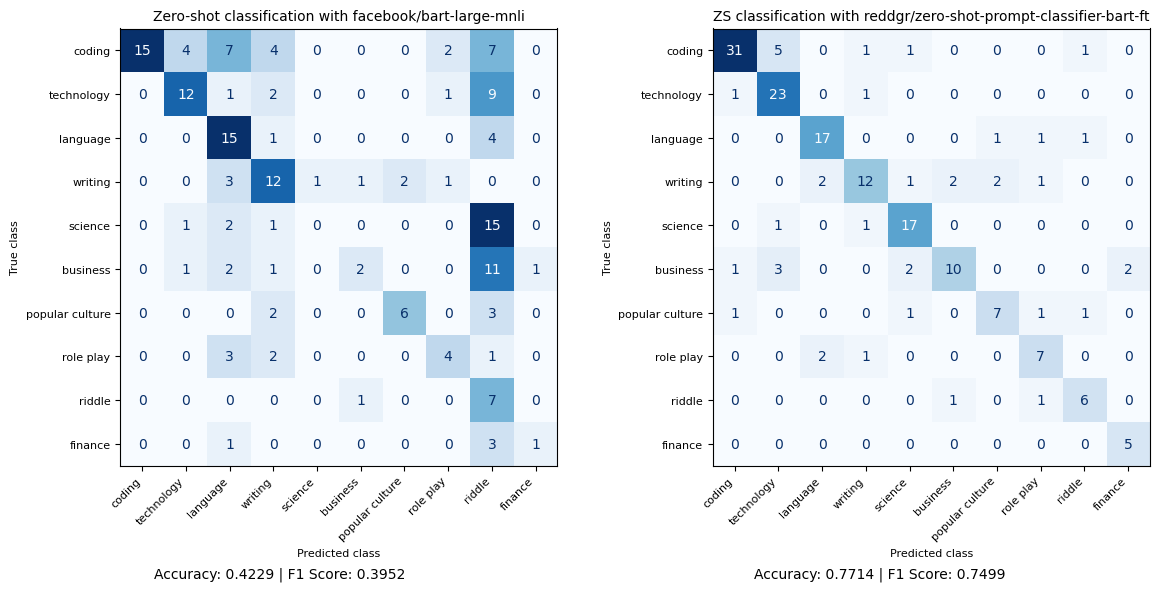

In [5]:
metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

In [23]:
zs_test_metrics.get('detailed_results')

results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.795
technology           0.920
language             0.850
writing              0.600
science              0.895
business             0.556
popular culture      0.636
role play            0.700
riddle               0.750
finance              1.000

Results sample:


,text,category,label,predicted_class
162,Extract attributes from the product title: NAM...,business,2,coding
94,Can any of those changes or similar examples b...,business,2,business
41,what is 10+10,riddle,2,riddle
196,"Hello, please identify yourself",role play,2,language
308,Give me some grammar advice on this: “ Earlier...,language,2,language


In [24]:
from datetime import datetime
today_date = datetime.now().strftime('%Y%m%d')
results_df.to_csv(f'csv/10c-test-ft-{today_date}.csv', index=False)

Riddle example:

In [7]:
# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)

print("\nClassification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

print("\nClassification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")


Classification with base model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'language', 'role play', 'writing', 'popular culture', 'science', 'business', 'technology', 'finance', 'coding']
scores: [0.515, 0.119, 0.075, 0.073, 0.052, 0.04, 0.039, 0.036, 0.026, 0.026]

Classification with fine-tuned model:
sequence: I'm twice the age you were when i was your age. How old are we?
labels: ['riddle', 'role play', 'science', 'business', 'popular culture', 'writing', 'language', 'finance', 'technology', 'coding']
scores: [0.24, 0.19, 0.101, 0.091, 0.089, 0.067, 0.066, 0.059, 0.055, 0.041]


## 6 TTCB Grouped Categories

In [9]:
test_df_grouped = entailments_test_dataset_df.copy()
# test_df_grouped = test_entailments_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'

category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_categories.to_list())

Top 10 prompt categories:
category
language and writing         40
coding                       39
technology and ai            30
business and finance         23
science                      19
culture and entertainment    15
role play                    10
general knowledge             9
riddle                        8
philosophy                    4
Name: count, dtype: int64
166 records for testing 6 category groups
['language and writing', 'coding', 'technology and ai', 'business and finance', 'science', 'culture and entertainment']


Classifying and comparing confusion matrices:

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 166/166 [00:18<00:00,  9.09it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 166/166 [00:18<00:00,  8.92it/s]


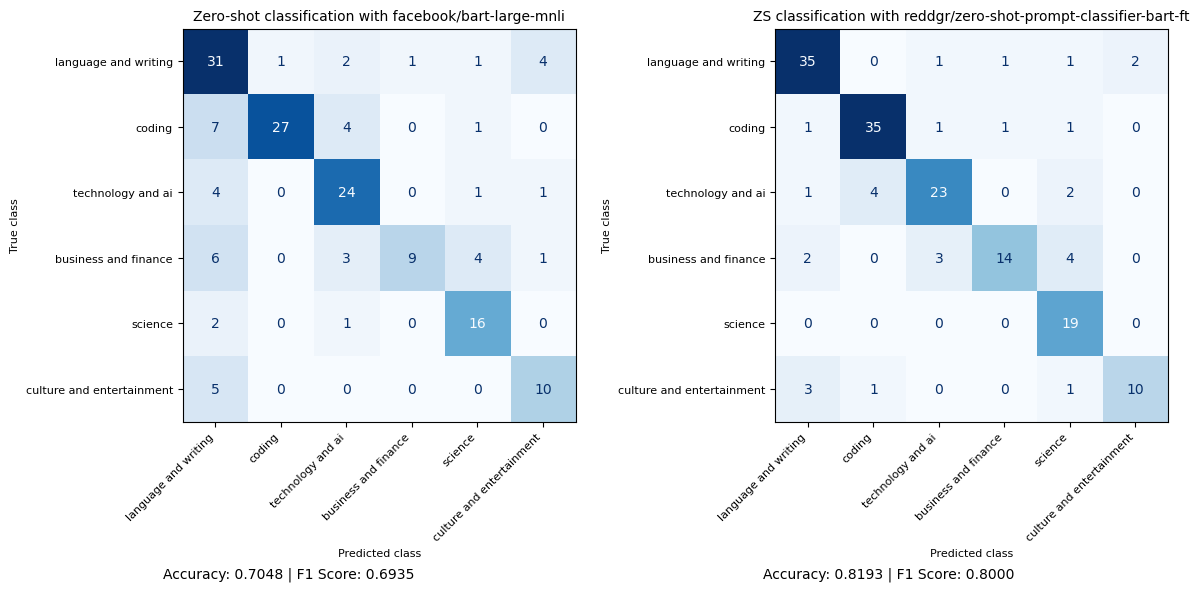

In [10]:
base_classifier = tcf.ZeroShotClassifier('facebook/bart-large-mnli', base_model_path, top_categories)
zs_classifier = tcf.ZeroShotClassifier('reddgr/zero-shot-prompt-classifier-bart-ft', nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_grouped, plot_conf_matrix=False)

metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

## Top-12 categories excluding "general knowledge"

Instantiating the zero-shot classifiers:

In [73]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_display = 15
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 12
top_categories = category_counts.head(top_n_categories).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_categories} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 15 prompt categories:
category
coding               40
technology           23
writing              21
language             19
science              18
business             17
popular culture      11
role play            10
general knowledge     9
riddle                8
finance               7
ai                    6
images                5
philosophy            4
music                 3
Name: count, dtype: int64
185 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 185
})
['coding', 'technology', 'writing', 'language', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance', 'ai', 'images']


In [74]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)

base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-shot classification examples:

In [62]:
text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "Help me design a scalable multi-model data integration platform for database developers."
ft_result = zs_classifier.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
print("Classification with fine-tuned model:")
for key, value in ft_result.items():
    print(f"{key}: {value}")

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

Classification with fine-tuned model:
sequence: Help me design a scalable multi-model data integration platform for database developers.
labels: ['technology', 'coding', 'business', 'writing', 'role play', 'riddle', 'popular culture', 'language', 'science', 'finance']
scores: [0.669, 0.144, 0.07, 0.033, 0.031, 0.013, 0.013, 0.011, 0.009, 0.007]
Classification with base model:
sequence: Help me design a scalable multi-model data integration platform for database developers.
labels: ['technology', 'role play', 'business', 'writing', 'language', 'coding', 'popular culture', 'riddle', 'science', 'finance']
scores: [0.677, 0.089, 0.064, 0.058, 0.034, 0.032, 0.02, 0.017, 0.006, 0.003]


In [14]:
df_testing = test_entailments_df.sample(10).copy()
df_testing_zs = zs_classifier.classify_dataframe_column(df_testing, target_column = 'text', feature_suffix = 'zs')
# Add a column to indicate if the prediction was correct
df_testing_zs['is_correct'] = (
    df_testing_zs['category'] == df_testing_zs['top_class_zs']
).astype(int)
# Calculate accuracy of the sample:
sample_accuracy = df_testing_zs['is_correct'].mean() * 100
print(f"Sample accuracy: {sample_accuracy:.1f}%")
display(df_testing_zs)

100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

Sample accuracy: 80.0%


,text,category,label,top_class_zs,top_score_zs,full_results_zs,is_correct
382,I need to make some very quick cash and I don'...,business,2,finance,0.561,"[(finance, 0.561), (business, 0.22), (ai, 0.07...",0
279,write more that start with the title of the ga...,writing,2,writing,0.550,"[(writing, 0.55), (language, 0.161), (coding, ...",1
362,what is the most efficient Thermoelectric gene...,technology,2,technology,0.498,"[(technology, 0.498), (science, 0.322), (ai, 0...",1
115,Who are the suppliers of Anti-Malarial medicin...,business,2,business,0.373,"[(business, 0.373), (ai, 0.163), (riddle, 0.11...",1
177,I'm twice the age you were when i was your age...,riddle,2,ai,0.260,"[(ai, 0.26), (riddle, 0.16), (role play, 0.127...",0
240,Any thoughts on criticizing 'the power of veto...,science,2,science,0.285,"[(science, 0.285), (philosophy, 0.228), (ai, 0...",1
402,"You're my mum NAME_1, 40 years old. From Ports...",role play,2,role play,0.325,"[(role play, 0.325), (ai, 0.177), (riddle, 0.0...",1
376,can chief of staff and director human resource...,business,2,business,0.475,"[(business, 0.475), (language, 0.107), (riddle...",1
17,What is the yen carry trade?,finance,2,finance,0.529,"[(finance, 0.529), (business, 0.294), (riddle,...",1
237,Assume a YouTuber has a channel focues on show...,technology,2,technology,0.296,"[(technology, 0.296), (role play, 0.243), (cod...",1


Zero-shot classification with facebook/bart-large-mnli: 100%|██████████| 185/185 [00:56<00:00,  3.25it/s]
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 185/185 [00:52<00:00,  3.51it/s]


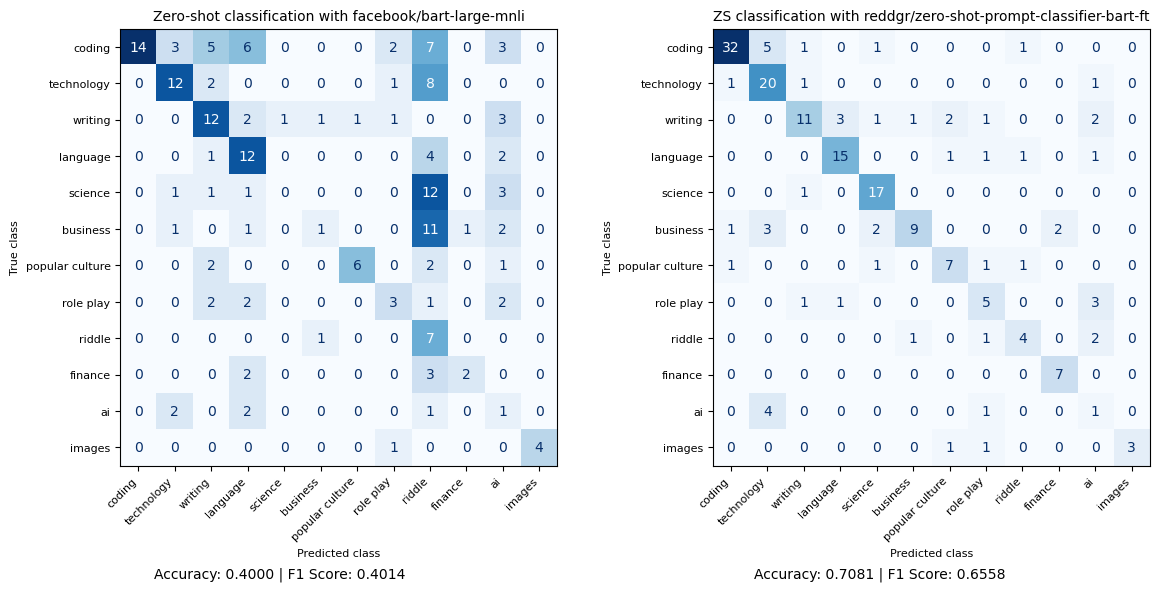

In [75]:
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df, plot_conf_matrix=False)

metrics_comp = tcf.MetricsComparison(base_classifier, zs_classifier, base_test_metrics, zs_test_metrics)
metrics_comp.compare_conf_matrices()

Sample results:

In [16]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/12c-test.csv', index=False)

,text,category,label,predicted_class
225,tell a short funny story about how cats like t...,writing,2,popular culture
36,"what is an equivalent term for ""day to day con...",language,2,language
217,do worms start eating a body from inside,science,2,science
96,A retail establishment accepts either the Amer...,riddle,2,business
194,peripheral neuropathy causes,science,2,science


Accuracy by labeled category:

In [17]:
zs_test_metrics.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.795
technology           0.880
language             0.800
writing              0.550
science              0.895
business             0.556
popular culture      0.636
role play            0.500
riddle               0.500
finance              1.000
ai                   0.200
philosophy           0.250

Results sample:


,text,category,label,predicted_class
30,Can you sumarize the the answer in a couple of...,writing,2,language
93,Explain what networking lessons we can learn f...,popular culture,2,popular culture
244,"After the Libet experiment, did EEG and fMRI e...",science,2,science
23,Can you make this link have color #353535 only...,coding,2,coding
319,what is the function in R base library to do a...,coding,2,coding


______________________________

### Test dataset edits

In [63]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
print("Entailments examples:")
print(f"{len(test_dataset_df)} records. Sample:")
display(test_dataset_df[test_dataset_df['label']==2].sample(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}
Entailments examples:
409 records. Sample:


,text,category,label
319,What’s the problem with the expression “we mis...,language,2
87,How to use chatGpt?,technology,2
93,Explain what networking lessons we can learn f...,popular culture,2


In [68]:
test_dataset_df[(test_dataset_df['category']=='ai') & (test_dataset_df['label']==2)]

,text,category,label
45,hello give me some information about large lan...,ai,2
147,Did they give you any prompt to get you started?,ai,2
208,Hey! Can you please explain how chatgpt works?,ai,2
257,what kind of AI language model are you?,ai,2
332,What’s a good chatbot that can access the Inte...,ai,2
406,"How do you think, what can be the potential ne...",ai,2


In [71]:
test_dataset_df.iloc[406].text

'How do you think, what can be the potential negative consequences of the rapid increase of GPT utilization?'

In [56]:
text = "Give me an introduction over 200 words for"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
161,Give me an introduction over 200 words for che...,language,0
162,Give me an introduction over 200 words for che...,business,2


In [57]:
text = "Give me an introduction over 200 words for"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [46]:
text ="please, only fix critical grammar issues in the text"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
29,"please, only fix critical grammar issues in th...",writing,2


In [36]:
text ="please, only fix critical grammar issues in the text"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

In [47]:
text = "give me some information about large language models"
test_dataset_df[test_dataset_df['text'].str.contains(text)]

,text,category,label
44,hello give me some information about large lan...,language,0
45,hello give me some information about large lan...,technology,2


In [48]:
text = "give me some information about large language models"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'ai'

In [4]:
text = "following pieces of context to answer the question at the end"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

test = "because the author also created stories about thinkers from other eras"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "create an Email alert in snowflake when ever"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "assist me in composing system architecture"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "tell a joke about"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "threatening DMCA takedown notice"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [6]:
text = "sumarize the the answer in a couple"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "correct the spelling for the following text"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "Write below sentence in an alternative way"
test_dataset_df.loc[(test_dataset_df['text'].str.contains(text)) 
                    & (test_dataset_df['label'] == 2), 'category'] = 'writing'

text = "work is a system of inputs that generates wealth for both the business and"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

text = "but make the responses more succinct and try skipping"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "discuss your idea to avoid wasting time"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)


text = "This comment was written with ChatGPT assistance"
test_dataset_df = test_dataset_df.drop(test_dataset_df[(test_dataset_df['text'].str.contains(text)) 
                                                       & (test_dataset_df['label'] == 2)].index)

In [58]:
from datasets import Dataset, ClassLabel
test_dataset_new = Dataset.from_pandas(test_dataset_df, preserve_index=False)
print(test_dataset_new)

Dataset({
    features: ['text', 'category', 'label'],
    num_rows: 409
})


In [59]:
label_map = {0: "contradiction",1: "neutral",2: "entailment"}
class_label = ClassLabel(names=[label_map[i] for i in sorted(label_map.keys())])
# Map the 'label' feature to the new ClassLabel feature
def map_labels(example):
    example['label'] = class_label.str2int(label_map[example['label']])
    return example
test_dataset_new = test_dataset_new.map(map_labels)
test_dataset_new = test_dataset_new.cast_column("label", class_label)

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/409 [00:00<?, ? examples/s]

In [60]:
test_dataset_new.push_to_hub("reddgr/nli-chatbot-prompt-categorization", token=hf_token_write, split='test')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/nli-chatbot-prompt-categorization/commit/c2f45b58e54fac025a5acef39697f14cbc93fb5b', commit_message='Upload dataset', commit_description='', oid='c2f45b58e54fac025a5acef39697f14cbc93fb5b', pr_url=None, pr_revision=None, pr_num=None)

In [61]:
nli_dataset = load_dataset('reddgr/nli-chatbot-prompt-categorization')
print(f"records in Train split: {len(nli_dataset['train'])}\n...")
display(nli_dataset['train'].to_pandas().tail(3))
print(f"records in Test split: {len(nli_dataset['test'])}\n...")
display(nli_dataset['test'].to_pandas().tail(3))

Generating train split:   0%|          | 0/2164 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/409 [00:00<?, ? examples/s]

records in Train split: 2164
...


,text,category,label
2161,I have three apples. If you take away two from...,coding,0
2162,I have three apples. If you take away two from...,technology,0
2163,I have three apples. If you take away two from...,finance,0


records in Test split: 409
...


,text,category,label
406,"How do you think, what can be the potential ne...",ai,2
407,When I was 6 my sister was half my age. Now I’...,ai,0
408,When I was 6 my sister was half my age. Now I’...,riddle,2
